In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 

sns.set_style("dark")

number of values to be dropped:
 False    1092
True       84
dtype: int64


<AxesSubplot: xlabel='chords', ylabel='count'>

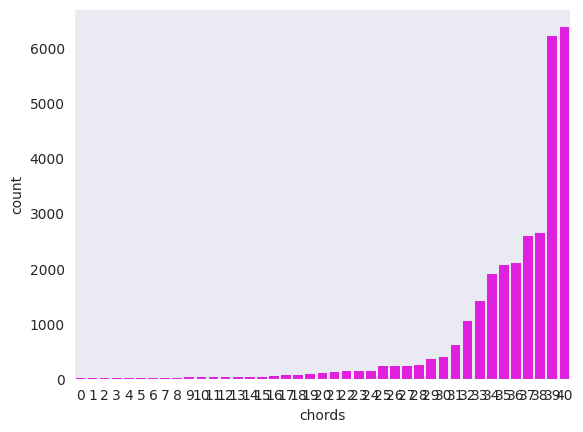

In [94]:
import os
import re
from collections import Counter

global control_var
control_var = True
def get_tuneBooks_file_names(path):
    tuneBook_filenames = []
    
    for tuneBook_name in os.listdir(path):
        if tuneBook_name.endswith('.abc'):
            tuneBook_filenames.append(tuneBook_name)
    
    #return ["jigs.abc"]
    return tuneBook_filenames
def split_abc_song(abc_song):
    k_index = abc_song.find('K:')

    split_index = abc_song.find('\n', k_index)

    header = abc_song[:split_index]
    body = abc_song[split_index+1:]
    return header, body

def tuneBook_to_dataframe(tuneBook):
    song_list = contents.split("\n\n")
    song_list = [song.strip() for song in song_list]
    songs_header_body_format = [split_abc_song(song) for song in song_list if song != '']
    """
    for (h,b) in songs_header_body_format:
        print("header")
        print(h)
        print("*"*10)
        print("body")
        print(b)
        print("\n")
        print("-"*50)
        print("\n")
    """
    
    return pd.DataFrame(songs_header_body_format, columns=['header', 'body'])

def get_attributes_from_song_header(tuneBook_df,tuneBook_name):
    attributes_column = tuneBook_df["header"]
    attributes_list = list(attributes_column)
    
    data = []
    for string in attributes_list:
        song = {}
        for line in string.split("\n"):
            if not line.startswith("%"):
                if ':' in line:
                    key, value = line.split(":", maxsplit=1)
                    song[key.strip()] = value.strip()
        data.append(song)

    df = pd.DataFrame(data)
    descriptive_names = {
                        'X': 'reference_number',
                        'T': 'title',
                        'S': 'source',
                        'M': 'meter',
                        'L': 'unit_note_length',
                        'R': 'rhythm',
                        'P': 'parts',
                        'K': 'key',
                        'F': 'file_name',
                        'N': 'notes'
                        }
    df.rename(columns=descriptive_names, inplace=True)
    df["tuneBook"] = tuneBook_name
    df["original_header"] =  tuneBook_df["header"]
    df["original_body"] =  tuneBook_df["body"]
    
    return df

def get_chord_progression(song_body):
    bars = song_body.split("|")
    chord_progression = "|"
    for bar_content in bars:
        match_chords = r'"[^"]*"'
        chords = re.findall(match_chords, bar_content)
        bar_chords = ''.join(chords)
        if bar_chords != "":
            chord_progression += bar_chords +'|'
    return chord_progression

def get_chord_occurrences(song_body):
    bars = song_body.split("|")
    chord_progression = "|"
    match_chords = r'"[^"]*"'
    chords = [re.findall(match_chords, bar_content)  for bar_content in bars if bar_content]
    chords = [chord for bar_chords in chords for chord in bar_chords]
    chord_occurrences = dict(Counter(chords))
    return chord_occurrences

def get_chords_data(song_body=""):
    #song_body = 'P:A\nD|"Gm"GB2G|"D7"^Fd2D|"Gm"GB2G|"D7"^FA2D|"Gm"GB2G|"D"^Fg -"Cm"gc|\\\n"Gm/d"B2 "D7"A2|"Gm"G3:|\nP:B\nd|"Gm"dg2d|"Gm"gb2d|"F"cf2c|"F"fa2c|"Eb"Be2d/2c/2|"Gm"dg -"Cm"gc|\\\n"Gm/d"B2 "D7"A2|"Gm"G3:|'
    clean_body_song = ""
    match_pattern = ""
    for line in song_body.splitlines():
        if not line.startswith("%"):
            if not "P:" in line:
                new_line = line.strip("\\")
                match_pattern = r"[: ]"
                new_line = re.sub(match_pattern, "", new_line)
                clean_body_song = clean_body_song+new_line

    
    chord_progression = get_chord_progression(clean_body_song)
    chords_data = get_chord_occurrences(clean_body_song)
    chords_data["chord_progression"] = chord_progression
    chords_data["clean_body"] = clean_body_song
    return chords_data

### treat strings line by line to ignore comments and parts!!!!!
def get_song_characteristics_from_body(tuneBook_df, header_col_name="original_body"):
    songs_bodies=tuneBook_df[header_col_name]
    #global control_var
    #print(songs_bodies)
    #if(control_var):
        #control_var = False
    #df = tuneBook_df.join(songs_bodies.apply(get_chords_data))
    new_data = songs_bodies.apply(get_chords_data)
    chords_df = new_data.apply(pd.Series)
    chords = chords_df['chord_progression']
    chords_df = chords_df.drop('chord_progression', axis=1)
    chords_df["chord_progression"] = chords
    tuneBook_df = tuneBook_df.join(chords_df)
    #print(tuneBook_df.columns)
    #print("*"*20)   
    # get anacrusis bool to see that the dataset is balanced
    #tuneBook["num_notes_per_bar"] # count num -> useless? to measure intensity?
    #tuneBook["num_bars"] # count number of || ins song -> to detect possible outliers?
    #tuneBook["num_notes_in_song"] # count a,b,c,d...in string, match regex "a"   
    #tuneBook["chord_progression"] #string "|"C"|"Dm"|" -> to count chords and to have a "Tree view of common chord progressions"
    #tuneBook["multiple_parts"] #bool -> to treat songs with multiple parts
    ##  Count types of notes in each song to see the proportion of notes for a given key
    ## Maybe by chord also?
    return tuneBook_df
def get_songs_metadata(songs_dataframe, tuneBook_name):
    #songs_dataframe["number_in_tunebook"] = get_attributes_from_song_header(songs_dataframe)
    df = get_attributes_from_song_header(songs_dataframe,tuneBook_name)
    df = get_song_characteristics_from_body(df)
    return df
def prepare_dataset_for_EDA(relative_path="",drop_by_occurrences=False, drop_by_extended_chord=True):
    absolute_path = os.getcwd()
    #relative_path = "notebooks/data/NottinghamData/nottingham_database"
    relative_path = "notebooks/data/NottinghamCleaned/nottingham_match/python/data/nottingham_jukedeck/ABC_cleaned"
    absolute_path = os.path.join(absolute_path, relative_path)
    songs_df = pd.DataFrame()
    list_tuneBooks = get_tuneBooks_file_names(absolute_path)
    for abc_tuneBook_filename in list_tuneBooks:
        file_path = os.path.join(absolute_path, abc_tuneBook_filename)
        
        with open(file_path) as tuneBook:
            contents = tuneBook.read()
            df = tuneBook_to_dataframe(contents)
            df1 = get_songs_metadata(df,abc_tuneBook_filename)
            songs_df = pd.concat([songs_df, df1], ignore_index=True)


    chords_names = songs_df.columns[songs_df.columns.str.contains('"[^"]*"')]

    songs_df[chords_names] = songs_df[chords_names].fillna(0).astype(int)

    chords_occurrences = songs_df[chords_names].sum().sort_values(ascending=True)

    #for current_chord,sum_chords in chords_occurrences.items():
    #    print(current_chord,sum_chords)

    chords_occurrences = chords_occurrences.reset_index(drop=True)
    chords_occurrences = chords_occurrences.reset_index()
    chords_occurrences_before_drop = chords_occurrences.rename({0:"count","index":"chords"},axis=1)
    chords_occurrences = songs_df[chords_names].sum()
    chords_names_to_be_dropped = []
    if(drop_by_occurrences):
        chords_names_least_occurrences = chords_occurrences[chords_occurrences<100].index.to_list()
        print("number chords least occurrences: ",len(chords_names_least_occurrences))

        mask_drop_songs_with_low_chords_sample = songs_df[chords_names_least_occurrences].apply(lambda row: row>0).any(axis=1)
        drop_num = mask_drop_songs_with_low_chords_sample.value_counts()
        print("number of values to be dropped:\n",drop_num)
        mask_drop_songs = mask_drop_songs_with_low_chords_sample
        chords_names_to_be_dropped = chords_names_least_occurrences
    #chords_most_occurrences = songs_df[chords_names_least_occurrences].sum().sort_values(ascending=True)
    #for current_chord,sum_chords in chords_most_occurrences.items():
    #    print(current_chord,sum_chords)

    if(drop_by_extended_chord):
        #extended_chords_names = songs_df.columns.str.filter("/")
        extended_chords_names = songs_df.columns[songs_df.columns.str.contains("/")].to_list()
        chords_names_to_be_dropped = extended_chords_names
        mask_drop_songs_with_extended_chords = songs_df[extended_chords_names].apply(lambda row: row>0).any(axis=1)
        drop_num = mask_drop_songs_with_extended_chords.value_counts()
        print("number of values to be dropped:\n",drop_num)
        mask_drop_songs = mask_drop_songs_with_extended_chords

    if(drop_by_occurrences or drop_by_extended_chord):
        clean_songs_df = songs_df[~mask_drop_songs]
        
    else:
        clean_songs_df = songs_df

    clean_songs_df = clean_songs_df.reset_index(drop=True)
    clean_songs_df.drop(chords_names_to_be_dropped, axis=1, inplace=True)

    mask_no_chord_progression = clean_songs_df["chord_progression"].str.len()>20
    clean_songs_df = clean_songs_df[mask_no_chord_progression]
    clean_songs_df = clean_songs_df.reset_index(drop=True)
    #for song in clean_songs_df["chord_progression"]:
    #    print(song)
    #    print("**"*10)
    return songs_df, clean_songs_df, chords_occurrences_before_drop

songs_df, clean_songs_df,chords_occurrences = prepare_dataset_for_EDA()
#chords_occurrences["count"] = chords_occurrences["count"].apply(np.log)
sns.barplot(data=chords_occurrences,y="count", x='chords',edgecolor='none',color="magenta")


In [95]:
songs_df["original_body"].str.contains("P:")

0       False
1       False
2       False
3        True
4       False
        ...  
1171    False
1172    False
1173     True
1174    False
1175    False
Name: original_body, Length: 1176, dtype: bool

<AxesSubplot: xlabel='key', ylabel='Count'>

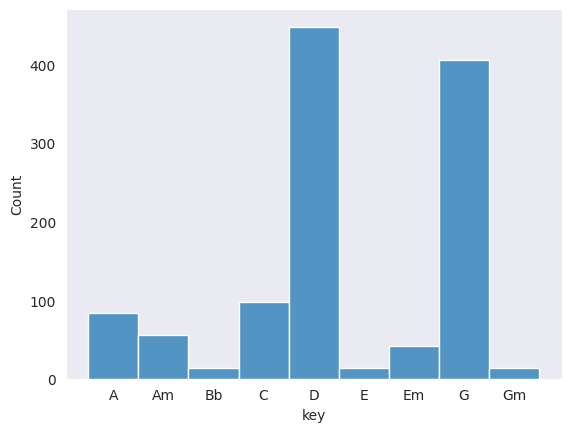

In [96]:
sns.histplot(songs_df["key"].astype("category"))

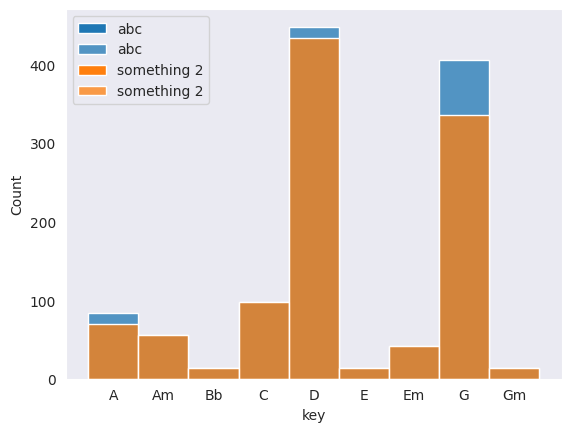

In [97]:
#fig, ax = plt.subplots()
ax = sns.histplot(songs_df["key"].astype("category"),label="abc")
ax = sns.histplot(clean_songs_df["key"].astype("category"), ax=ax,label="something 2")
ax.legend()
plt.show()

<AxesSubplot: xlabel='key', ylabel='Count'>

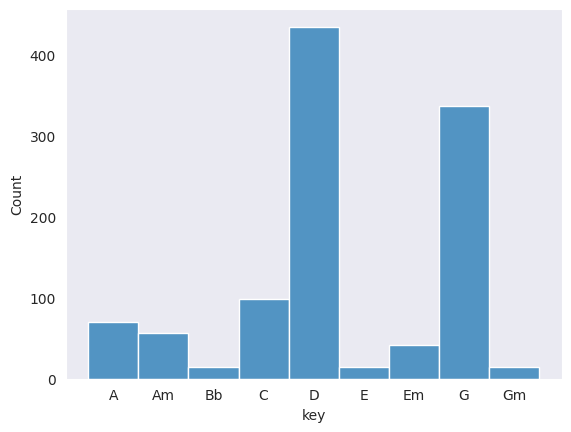

In [98]:
sns.histplot(clean_songs_df["key"].astype("category"))

In [100]:
clean_songs_df.columns[clean_songs_df.columns.str.contains('"')]

Index(['"G"', '"D"', '"C"', '"D7"', '"Em"', '"A7"', '"E7"', '"A"', '"Bm"',
       '"Fa7"', '"E"', '"Am"', '"B7"', '"F#m"', '"Gd"', '"F"', '"Bb"', '"Eb"',
       '"C7"', '"F7"', '"Dm"', '"Gm"', '"G7"', '"C#m"', '"F#7"', '"C#7"',
       '"F#"', '"Ed"', '"Ab"', '"Cm"', '"Fm"', '"Cm6"'],
      dtype='object')

In [92]:
print(clean_songs_df["chord_progression"].str.contains("segno").value_counts())

False    1078
Name: chord_progression, dtype: int64
